In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
df1 = pd.read_csv('Data.csv')
df2 = pd.read_csv('material.csv')

In [4]:
# Ghép DataFrame và loại bỏ các cột trùng nhau
df = pd.concat([df1, df2.loc[:, ~df2.columns.isin(df1.columns)]], axis=1)
df.to_csv('material_merge.csv')

In [5]:
df.head()

,Std,ID,Material,Heat treatment,Su,Sy,A5,Bhn,E,G,mu,Ro,pH,Desc,HV,Use
0,ANSI,D8894772B88F495093C43AF905AB6373,Steel SAE 1015,as-rolled,421,314,39.0,126.0,207000,79000,0.3,7860,NaN,NaN,NaN,True
1,ANSI,05982AC66F064F9EBC709E7A4164613A,Steel SAE 1015,normalized,424,324,37.0,121.0,207000,79000,0.3,7860,NaN,NaN,NaN,True
2,ANSI,356D6E63FF9A49A3AB23BF66BAC85DC3,Steel SAE 1015,annealed,386,284,37.0,111.0,207000,79000,0.3,7860,NaN,NaN,NaN,True
3,ANSI,1C758F8714AC4E0D9BD8D8AE1625AECD,Steel SAE 1020,as-rolled,448,331,36.0,143.0,207000,79000,0.3,7860,NaN,NaN,NaN,True
4,ANSI,DCE10036FC1946FC8C9108D598D116AD,Steel SAE 1020,normalized,441,346,35.8,131.0,207000,79000,0.3,7860,550.0,NaN,NaN,True


In [6]:
df = df.drop(['ID'],axis=1)

In [ ]:
# 1. Thay thế giá trị NaN bằng chuỗi 'Missing'
df['Desc'].fillna('Missing', inplace=True)
# 3. Gộp cột, giữ lại giá trị NaN đã thay thế
df['Material'] = df['Material'] + df['Desc']

C:\Users\gvu03\AppData\Local\Temp\ipykernel_19904\1580273652.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Desc'].fillna('Missing', inplace=True)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552 entries, 0 to 1551
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Std             1552 non-null   object 
 1   Material        1552 non-null   object 
 2   Heat treatment  802 non-null    object 
 3   Su              1552 non-null   int64  
 4   Sy              1552 non-null   object 
 5   A5              1346 non-null   float64
 6   Bhn             463 non-null    float64
 7   E               1552 non-null   int64  
 8   G               1552 non-null   int64  
 9   mu              1552 non-null   float64
 10  Ro              1552 non-null   int64  
 11  pH              193 non-null    float64
 12  Desc            1552 non-null   object 
 13  HV              165 non-null    float64
 14  Use             1552 non-null   bool   
dtypes: bool(1), float64(5), int64(4), object(5)
memory usage: 171.4+ KB


In [9]:
df.isnull().sum()

Std                  0
Material             0
Heat treatment     750
Su                   0
Sy                   0
A5                 206
Bhn               1089
E                    0
G                    0
mu                   0
Ro                   0
pH                1359
Desc                 0
HV                1387
Use                  0
dtype: int64

In [10]:
# Bước 2: Loại bỏ các biến chất lượng thấp
threshold = len(df) * 0.5
df = df.dropna(thresh=threshold, axis=1)

In [11]:
df.head()

,Std,Material,Heat treatment,Su,Sy,A5,E,G,mu,Ro,Desc,Use
0,ANSI,Steel SAE 1015Missing,as-rolled,421,314,39.0,207000,79000,0.3,7860,Missing,True
1,ANSI,Steel SAE 1015Missing,normalized,424,324,37.0,207000,79000,0.3,7860,Missing,True
2,ANSI,Steel SAE 1015Missing,annealed,386,284,37.0,207000,79000,0.3,7860,Missing,True
3,ANSI,Steel SAE 1020Missing,as-rolled,448,331,36.0,207000,79000,0.3,7860,Missing,True
4,ANSI,Steel SAE 1020Missing,normalized,441,346,35.8,207000,79000,0.3,7860,Missing,True


Xử lí đặc trưng
-Heat treatment theo code duoi nan thanh 1 loai
-Material phan loai theo vat lieu (steel brozen allunium)

In [12]:
# Từ khóa cho từng loại phân loại
keywords = {
    "Heat Treatment": ["heat treated", "annealed", "tempered", "quenched", "nitrided"],
    "Cold Working": ["cold working"],
    "Casting": ["cast", "die casting", "sand casting"],
    "Cooling Methods": ["quenching", "cooling"],
    "Surface Hardening": ["case-hardened", "face hardened"],
    "Finished Products": ["wrought", "as-rolled"]
}

def classify_term(term):
    # Kiểm tra nếu term là chuỗi thì mới tiếp tục
    if isinstance(term, str):
        categories = []
        for category, words in keywords.items():
            if any(word.lower() in term.lower() for word in words):
                categories.append(category)
        return ', '.join(categories) if categories else 'Other'
    else:
        return 'Invalid'

# Áp dụng hàm để phân loại dữ liệu
df['category'] = df['Heat treatment'].apply(classify_term)

df.head()


,Std,Material,Heat treatment,Su,Sy,A5,E,G,mu,Ro,Desc,Use,category
0,ANSI,Steel SAE 1015Missing,as-rolled,421,314,39.0,207000,79000,0.3,7860,Missing,True,Finished Products
1,ANSI,Steel SAE 1015Missing,normalized,424,324,37.0,207000,79000,0.3,7860,Missing,True,Other
2,ANSI,Steel SAE 1015Missing,annealed,386,284,37.0,207000,79000,0.3,7860,Missing,True,Heat Treatment
3,ANSI,Steel SAE 1020Missing,as-rolled,448,331,36.0,207000,79000,0.3,7860,Missing,True,Finished Products
4,ANSI,Steel SAE 1020Missing,normalized,441,346,35.8,207000,79000,0.3,7860,Missing,True,Other


In [13]:
# Từ khóa cho từng loại phân loại
keywords = {
    "steel": ["steel"],
    "bronze": ["bronze","copper","brass","spercial","muntz"],
    "silver": ["silver"],
    "iron": ["iron"],
    "alu": ["aluminum"],
    "magie": ["magnesium"]
}

# Áp dụng hàm để phân loại dữ liệu
df['material_type'] = df['Material'].apply(classify_term)
df.head()

,Std,Material,Heat treatment,Su,Sy,A5,E,G,mu,Ro,Desc,Use,category,material_type
0,ANSI,Steel SAE 1015Missing,as-rolled,421,314,39.0,207000,79000,0.3,7860,Missing,True,Finished Products,steel
1,ANSI,Steel SAE 1015Missing,normalized,424,324,37.0,207000,79000,0.3,7860,Missing,True,Other,steel
2,ANSI,Steel SAE 1015Missing,annealed,386,284,37.0,207000,79000,0.3,7860,Missing,True,Heat Treatment,steel
3,ANSI,Steel SAE 1020Missing,as-rolled,448,331,36.0,207000,79000,0.3,7860,Missing,True,Finished Products,steel
4,ANSI,Steel SAE 1020Missing,normalized,441,346,35.8,207000,79000,0.3,7860,Missing,True,Other,steel


In [14]:
df = df.drop(['Heat treatment','Material','Desc'],axis=1)

In [15]:
df['A5'].fillna(df["A5"].median(),inplace=True)

C:\Users\gvu03\AppData\Local\Temp\ipykernel_19904\3348592548.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['A5'].fillna(df["A5"].median(),inplace=True)


In [16]:
label_encoder = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = label_encoder.fit_transform(df[col])

In [17]:
df.describe()

,Std,Su,Sy,A5,E,G,mu,Ro,category,material_type
count,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000
mean,2.283505,572.753222,135.181057,18.887500,164571.520619,85598.840206,0.302977,6929.843428,4.418814,5.186211
std,2.272145,326.834927,77.071312,11.622757,56135.405867,125326.800138,0.024590,2115.171710,1.409137,2.484924
min,0.000000,69.000000,0.000000,0.500000,73000.000000,26000.000000,0.200000,1750.000000,0.000000,0.000000
25%,0.000000,340.000000,77.000000,12.000000,105000.000000,40000.000000,0.300000,7160.000000,4.000000,2.000000
50%,2.000000,500.000000,123.000000,16.000000,206000.000000,79000.000000,0.300000,7860.000000,5.000000,7.000000
75%,4.000000,705.000000,193.000000,22.000000,206000.000000,80000.000000,0.320000,7860.000000,5.000000,7.000000
max,7.000000,2220.000000,290.000000,70.000000,219000.000000,769000.000000,0.350000,8930.000000,7.000000,7.000000


In [18]:
# Số lượng mẫu trùng lặp
num_duplicates = df.duplicated().sum()
print(f"Số lượng mẫu trùng lặp: {num_duplicates}")
# Xoa cac mau trung lap
df = df.drop_duplicates()

Số lượng mẫu trùng lặp: 139


In [19]:
df.to_csv('material_final.csv')

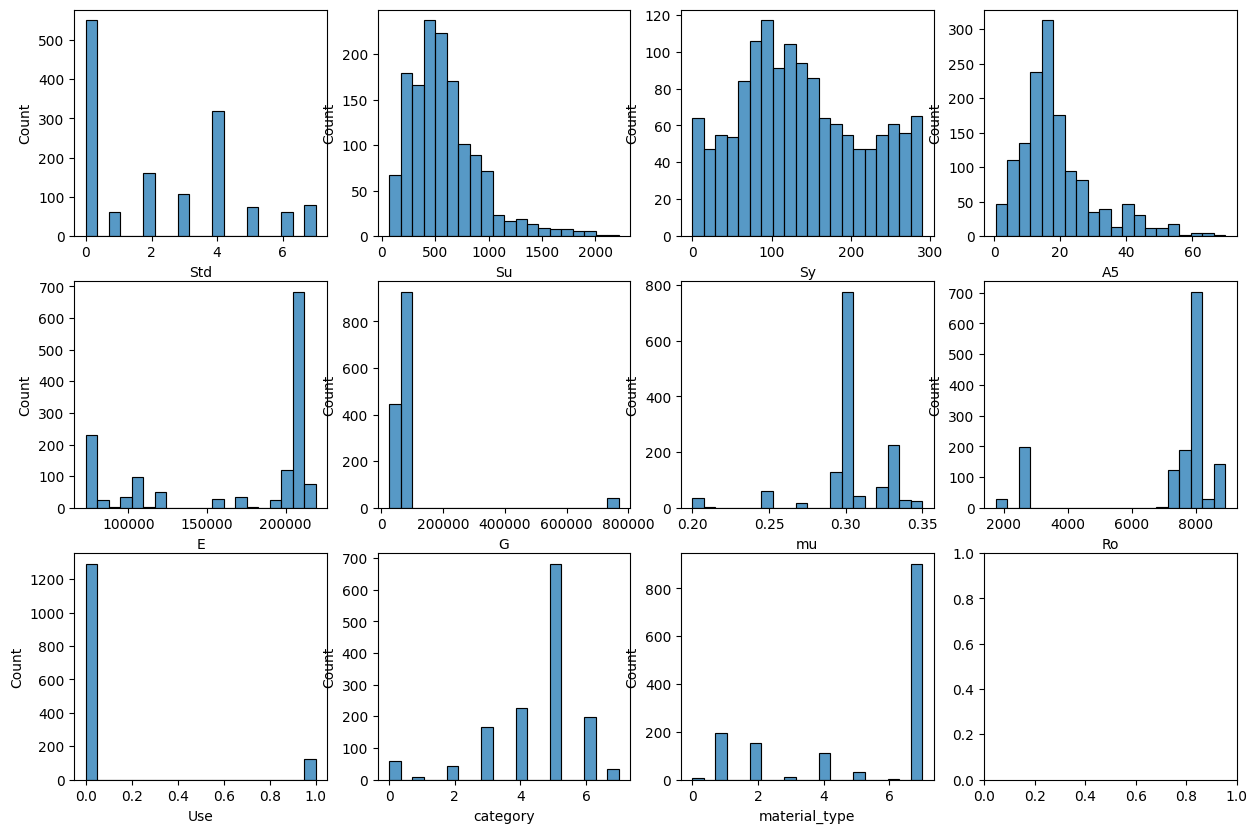

In [20]:
fig, ax = plt.subplots(3, 4, figsize=(15, 10))

for i, col in enumerate(df.columns):
    sns.histplot(df[col], ax=ax[i//4][i%4],bins=20)

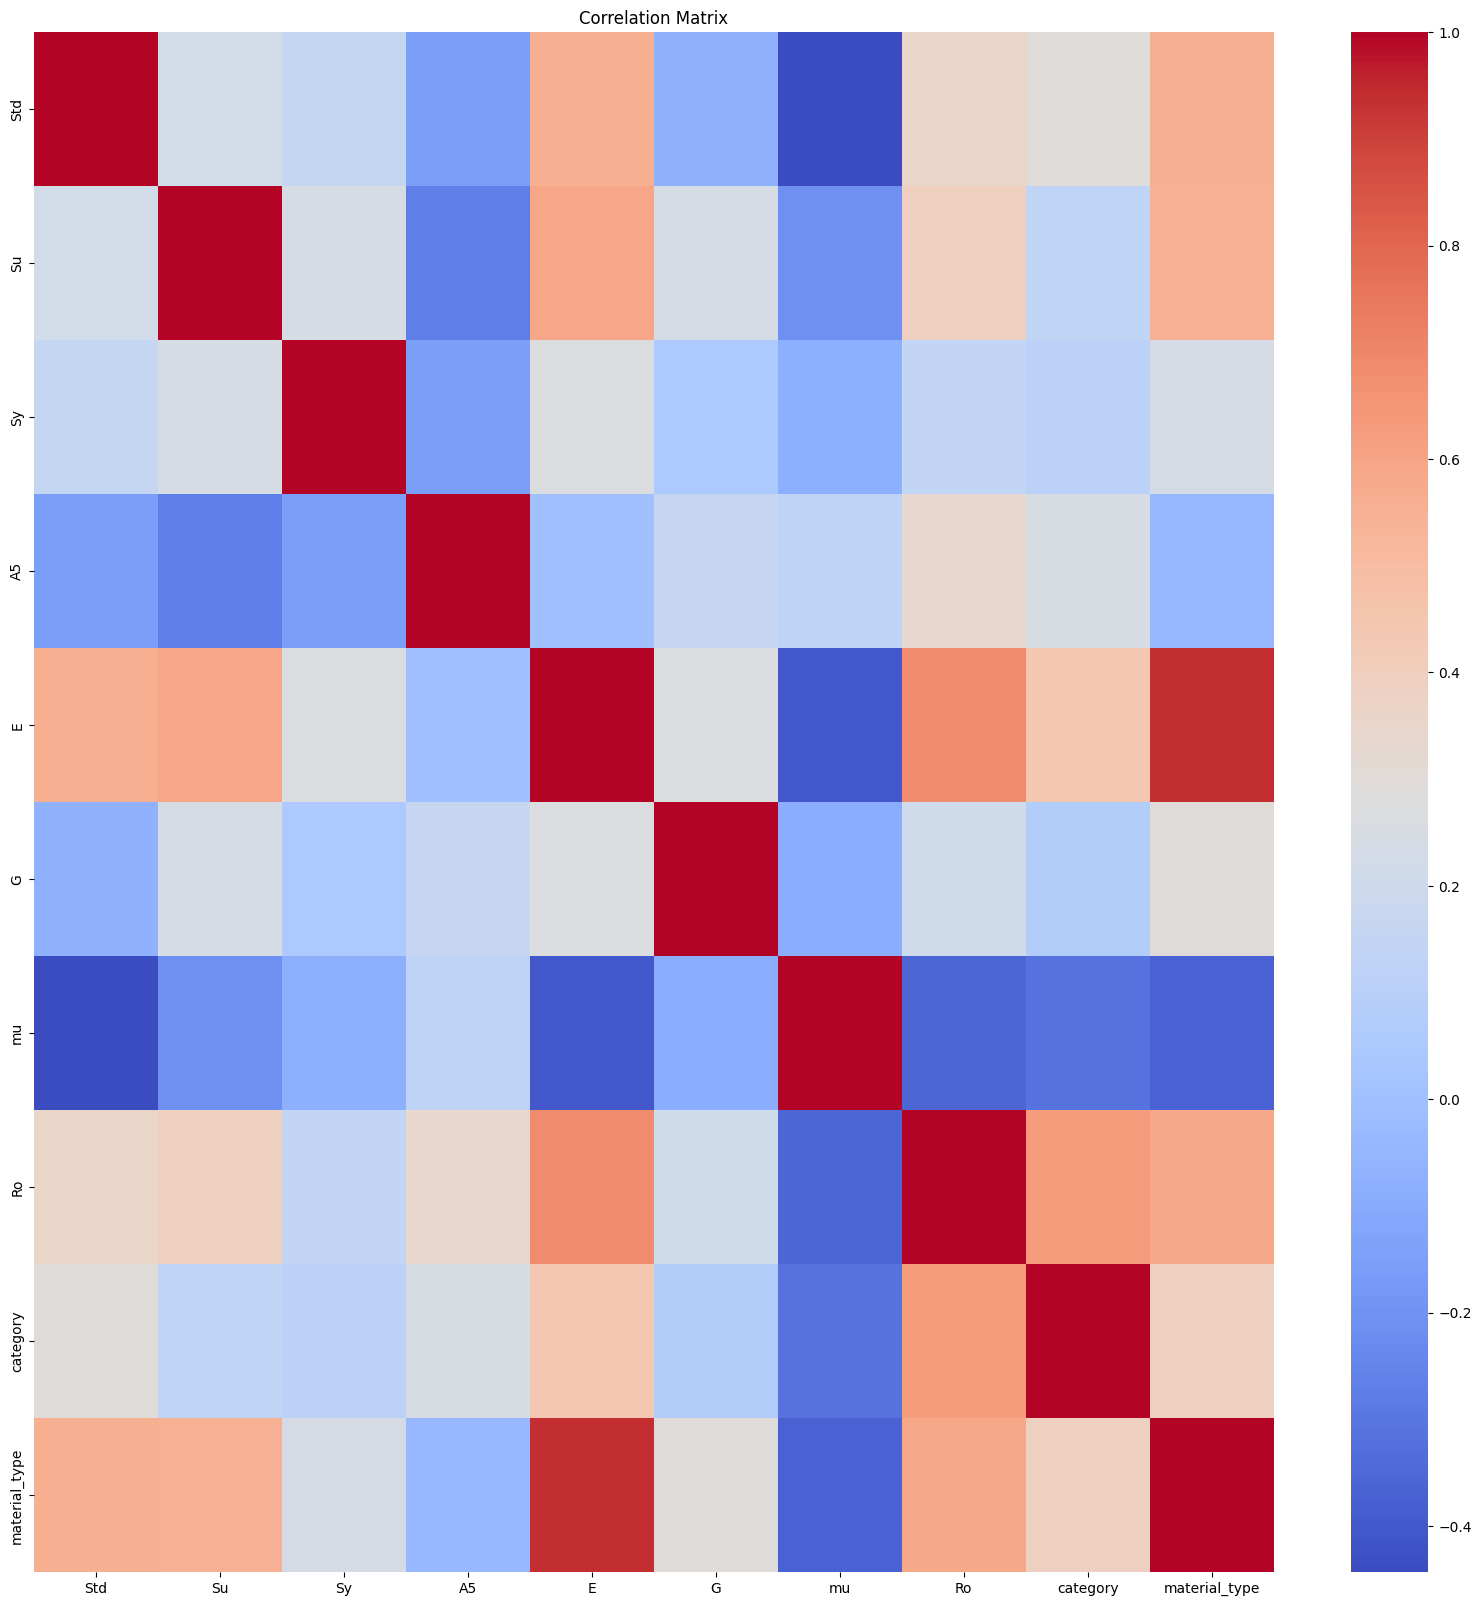

In [21]:
numeric_df = df.drop('Use', axis=1)

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [22]:
X = df.drop('Use',axis=1)
y = df['Use']

In [23]:
from imblearn.over_sampling import SMOTE
# Áp dụng SMOTE
smote = SMOTE(random_state=42)
X_resampled_ori, y_resampled_ori = smote.fit_resample(X, y)

# Kiểm tra lại sự cân bằng của dữ liệu
print("Số lượng mẫu trước khi áp dụng SMOTE:", dict(pd.Series(y).value_counts()))
print("Số lượng mẫu sau khi áp dụng SMOTE:", dict(pd.Series(y_resampled_ori).value_counts()))

Số lượng mẫu trước khi áp dụng SMOTE: {False: 1291, True: 122}
Số lượng mẫu sau khi áp dụng SMOTE: {True: 1291, False: 1291}


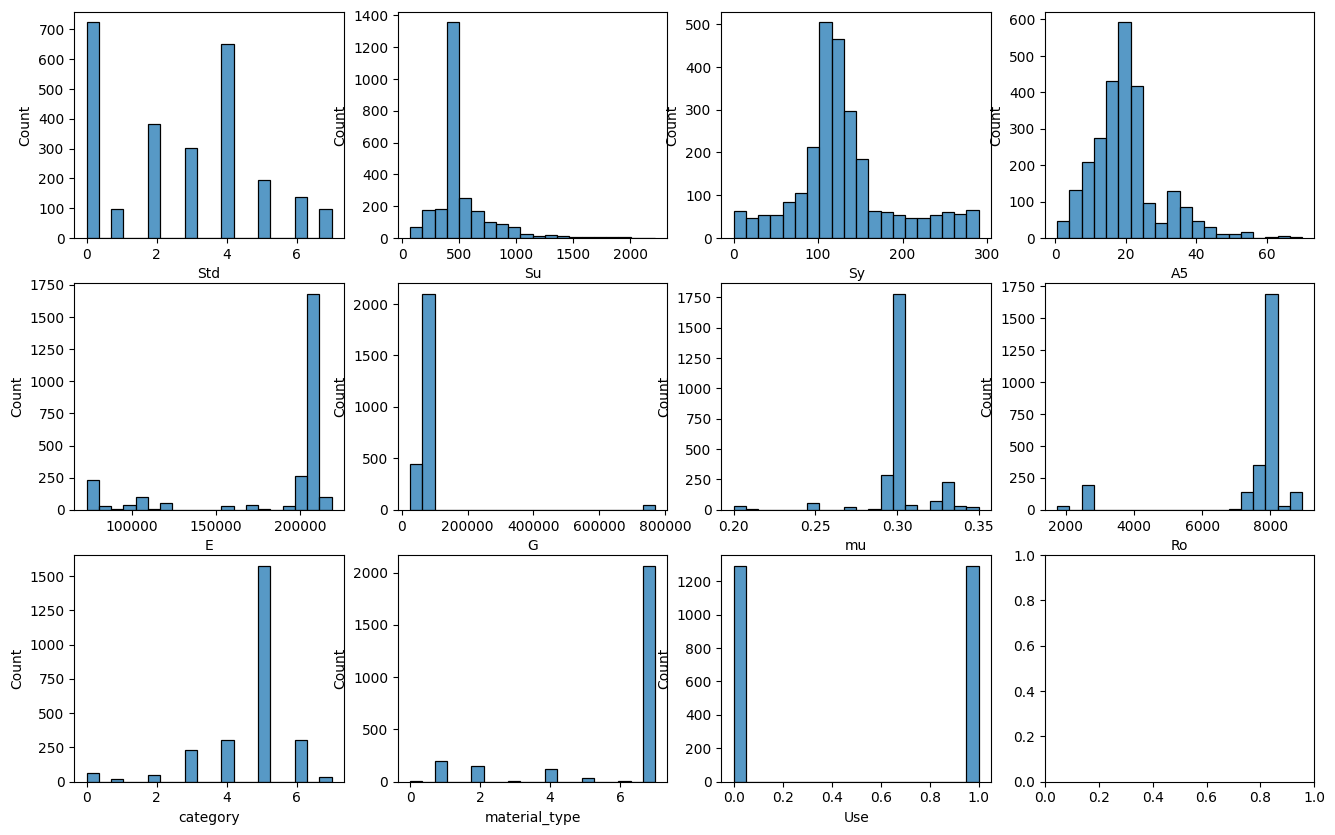

In [24]:
fig, ax = plt.subplots(3, 4, figsize=(16, 10))
df_smote_ori = pd.concat([X_resampled_ori,y_resampled_ori],axis=1)
for i, col in enumerate(df_smote_ori.columns):
    sns.histplot(df_smote_ori[col], ax=ax[i//4][i%4], bins=20) 

In [25]:
from imblearn.over_sampling import BorderlineSMOTE
# Áp dụng Borderline-SMOTE lên tập huấn luyện
borderline_smote = BorderlineSMOTE(random_state=42)
X_resampled_bd, y_resampled_bd = borderline_smote.fit_resample(X, y)

# Kiểm tra lại sự cân bằng của dữ liệu
print("Số lượng mẫu trước khi áp dụng SMOTE:", dict(pd.Series(y).value_counts()))
print("Số lượng mẫu sau khi áp dụng SMOTE:", dict(pd.Series(y_resampled_bd).value_counts()))

Số lượng mẫu trước khi áp dụng SMOTE: {False: 1291, True: 122}
Số lượng mẫu sau khi áp dụng SMOTE: {True: 1291, False: 1291}


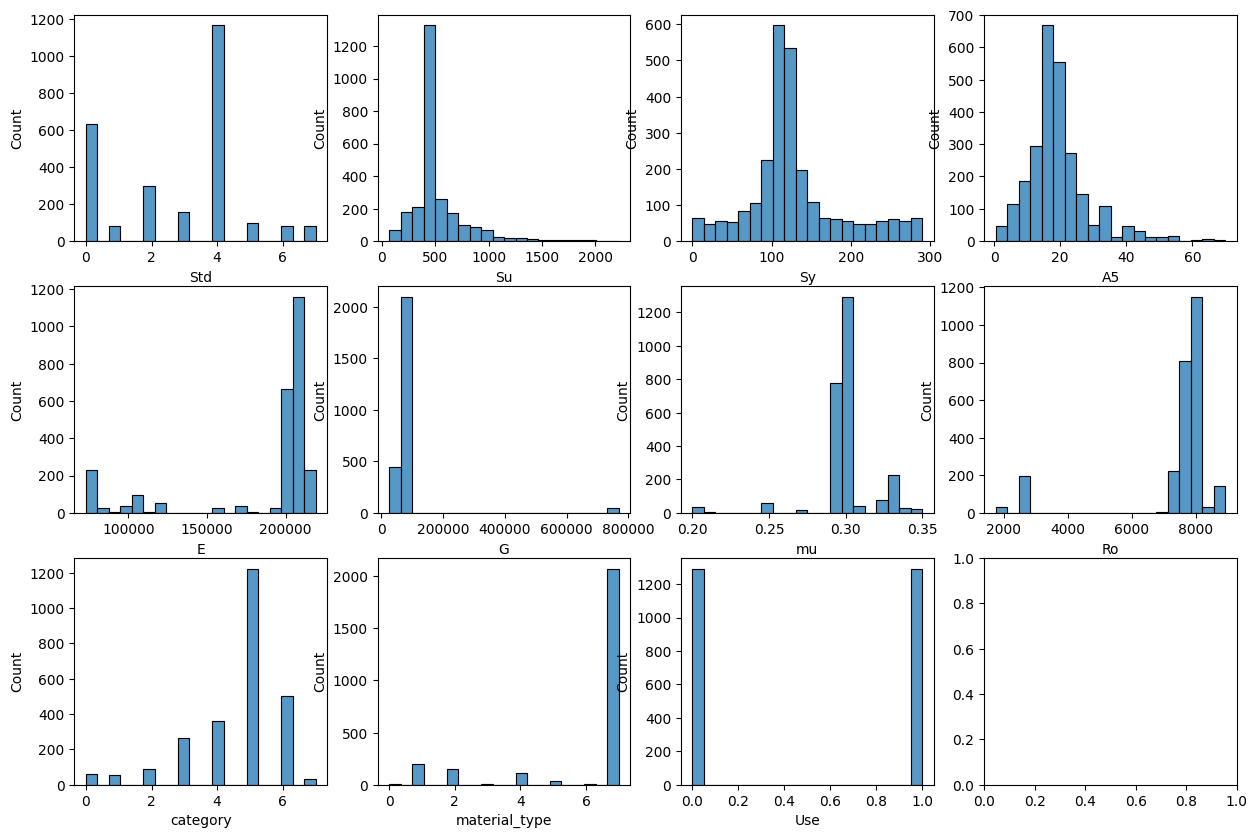

In [26]:
fig, ax = plt.subplots(3, 4, figsize=(15, 10))
df_smote_bd = pd.concat([X_resampled_bd,y_resampled_bd],axis=1)
for i, col in enumerate(df_smote_bd.columns):
    sns.histplot(df_smote_bd[col], ax=ax[i//4][i%4], bins=20) 

In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
colum = df_smote_bd.columns.drop(['Use','category','material_type','Std'])
df_smote_bd[colum]=scaler.fit_transform(df_smote_bd[colum])

In [28]:
df_smote_bd.describe()

,Std,Su,Sy,A5,E,G,mu,Ro,category,material_type
count,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000,2582.000000
mean,2.831526,0.215095,0.440988,0.269026,0.761350,0.075851,0.658093,0.784862,4.568552,6.064291
std,1.942780,0.118406,0.203655,0.134378,0.305873,0.120082,0.127258,0.212979,1.356513,1.984181
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.163180,0.351724,0.204749,0.869863,0.068641,0.600000,0.845265,4.000000,7.000000
50%,4.000000,0.195258,0.403448,0.248467,0.909421,0.071332,0.666667,0.850000,5.000000,7.000000
75%,4.000000,0.224547,0.493103,0.309353,0.910959,0.072678,0.666667,0.850975,5.000000,7.000000
max,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,7.000000


In [29]:
X = df_smote_bd.drop('Use',axis=1)
y = df_smote_bd['Use']

In [30]:
from sklearn.model_selection import train_test_split
#  Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
from sklearn.neighbors import KNeighborsClassifier

# Khởi tạo mô hình KNN với số lượng láng giềng k = 5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

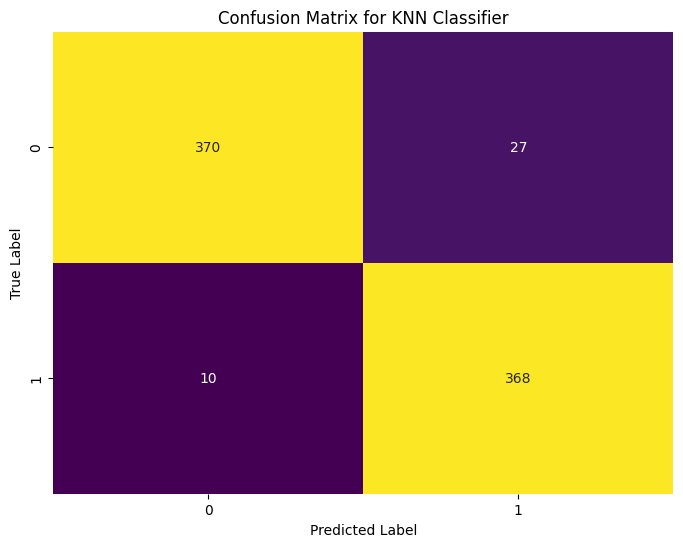

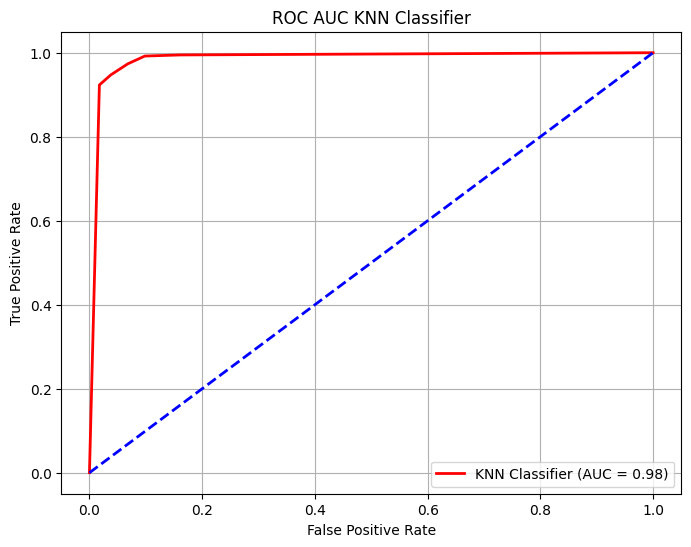

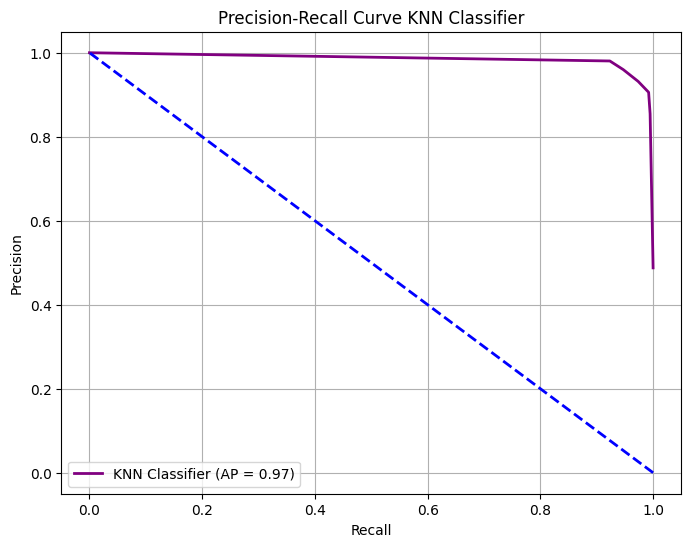

In [32]:
y_pred_knn = knn.predict(X_test)
y_prob_knn = knn.predict_proba(X_test)[:, 1]
# Ma trận nhầm lẫn (Confusion Matrix Heatmap)
cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=False)
plt.title('Confusion Matrix for KNN Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Biểu đồ ROC (ROC Curve)
fpr, tpr, _ = roc_curve(y_test, y_prob_knn)
roc_auc = roc_auc_score(y_test, y_prob_knn)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'KNN Classifier (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC KNN Classifier')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Biểu đồ Precision-Recall (Precision-Recall Curve)
precision, recall, _ = precision_recall_curve(y_test, y_prob_knn)
average_precision = average_precision_score(y_test, y_prob_knn)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'KNN Classifier (AP = {average_precision:.2f})')
plt.plot([1, 0], [0, 1], color='blue', linestyle='--', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve KNN Classifier')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


In [33]:
# Tính Precision, Recall, F1-score, và Accuracy
precision = precision_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)
accuracy = accuracy_score(y_test, y_pred_knn)

# In ra kết quả
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")

Precision: 0.932
Recall: 0.974
F1-score: 0.952
Accuracy: 0.952


In [34]:
from sklearn.svm import SVC

#  huấn luyện mô hình SVM
svc = SVC(kernel='linear',probability=True)
svc.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

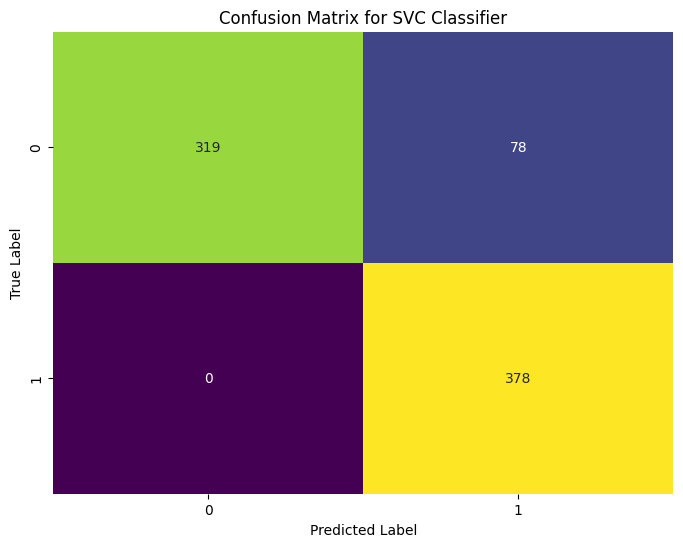

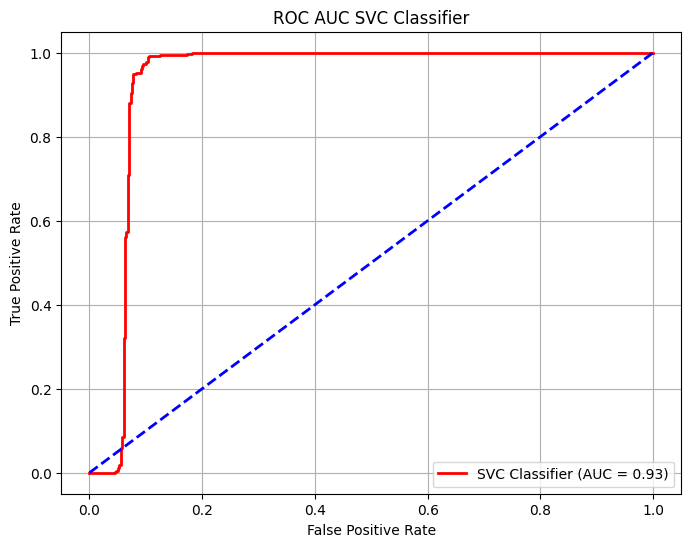

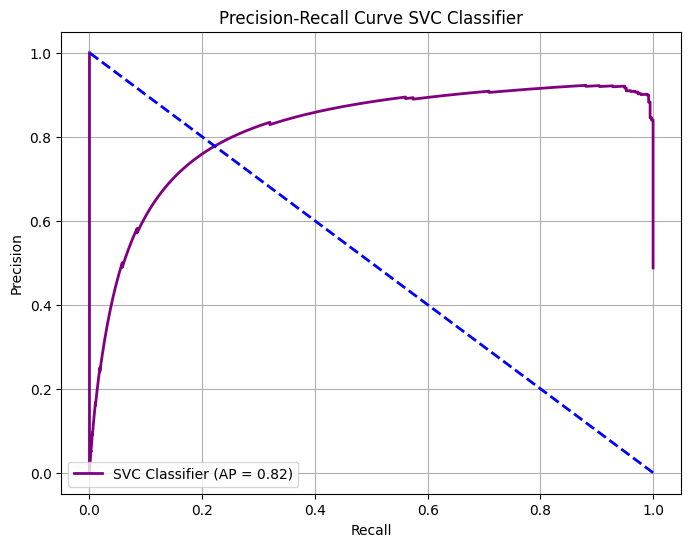

In [35]:
y_pred_svc = svc.predict(X_test)
y_prob_svc = svc.predict_proba(X_test)[:, 1]
# Ma trận nhầm lẫn (Confusion Matrix Heatmap)
cm = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=False)
plt.title('Confusion Matrix for SVC Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Biểu đồ ROC (ROC Curve)
fpr, tpr, _ = roc_curve(y_test, y_prob_svc)
roc_auc = roc_auc_score(y_test, y_prob_svc)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'SVC Classifier (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC SVC Classifier')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Biểu đồ Precision-Recall (Precision-Recall Curve)
precision, recall, _ = precision_recall_curve(y_test, y_prob_svc)
average_precision = average_precision_score(y_test, y_prob_svc)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'SVC Classifier (AP = {average_precision:.2f})')
plt.plot([1, 0], [0, 1], color='blue', linestyle='--', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve SVC Classifier')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

In [36]:
# Tính Precision, Recall, F1-score, và Accuracy
precision = precision_score(y_test, y_pred_svc)
recall = recall_score(y_test, y_pred_svc)
f1 = f1_score(y_test, y_pred_svc)
accuracy = accuracy_score(y_test, y_pred_svc)

# In ra kết quả
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")

Precision: 0.829
Recall: 1.000
F1-score: 0.906
Accuracy: 0.899
